In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# Линейная регрессия

### Простая линейная регрессия

Прямолинейная аппроксимация представляет собой модель вида 
$y = ax + b$, 
в которой
$a$ известна как угловой коэффициент, а $b$ — как точка пересечения с осью координат Y.

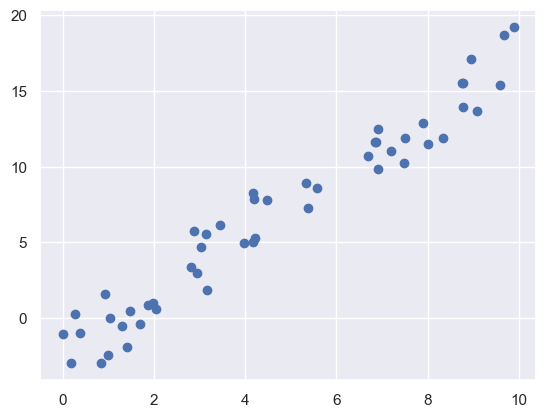

In [4]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 * rng.rand(50)
plt.scatter(x, y)

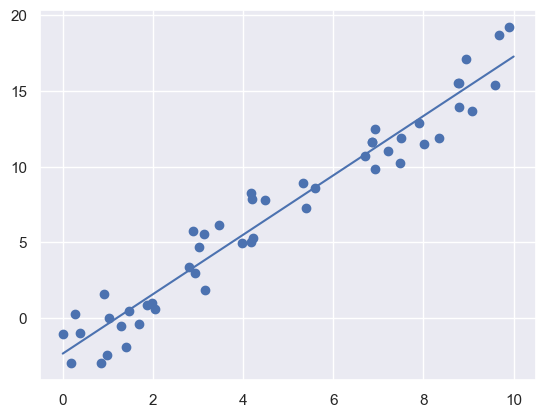

In [5]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)
model.fit(x[:, np.newaxis], y)
x_fit = np.linspace(0, 10, 1000)
y_fit = model.predict(x_fit[:, np.newaxis])
plt.scatter(x, y)
plt.plot(x_fit, y_fit)

In [6]:
print("Model slope: ", model.coef_[0])
print("Model intercept:", model.intercept_)

Model slope:  1.958848783861246
Model intercept: -2.331735139504345


### Регрессия по комбинации базисных функций

Идея состоит в том, чтобы взять многомерную линейную модель:
$y = a_0 + a_1x_1 + a_2x_2 + a_3x_3 + …$ 
и построить $x_1, x_2, x_3$ и т. д. на основе имеющегося одномерного входного значения $x$.
То есть у нас $x_n = f_n(x)$, где $f_n(x)$ — некая функция, выполняющая преобразование данных.
Например, если $f_n(x) = x^n$, наша модель превращается в полиномиальную регрессию:
$y = a_0 + a_1x + a_2x^2 + a_3x^3 + …$

Модель по-прежнему остается линейной — линейность относится к тому, что коэффициенты $a_n$ никогда не умножаются и не делятся друг на друга.

In [2]:
from sklearn.preprocessing import PolynomialFeatures
x = np.array([2, 3, 4])
poly = PolynomialFeatures(degree=3, include_bias=False)
poly.fit_transform(x[:, None])

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

Преобразователь превратил наш одномерный массив в трехмерный путем возведения каждого из значений в степень

In [7]:
# через конвейер
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(degree=7), LinearRegression())

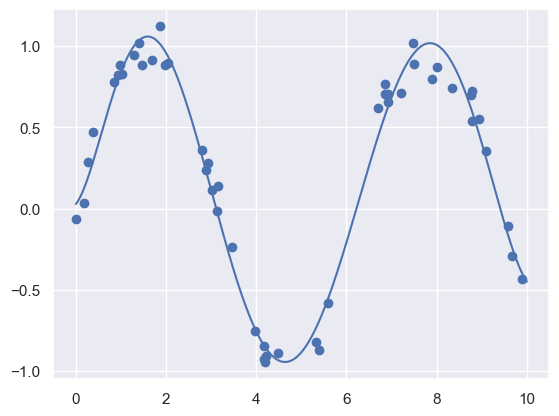

In [9]:
# зашумленная синусоида
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

poly_model.fit(x[:, np.newaxis], y)
x_fit = np.linspace(0, 10, 1000)
y_fit = poly_model.predict(x_fit[:, np.newaxis])
plt.scatter(x, y)
plt.plot(x_fit, y_fit)

### Гауссовы базисные функции

Аппроксимация нелинейных данных с помощью Гауссовых базисных функций
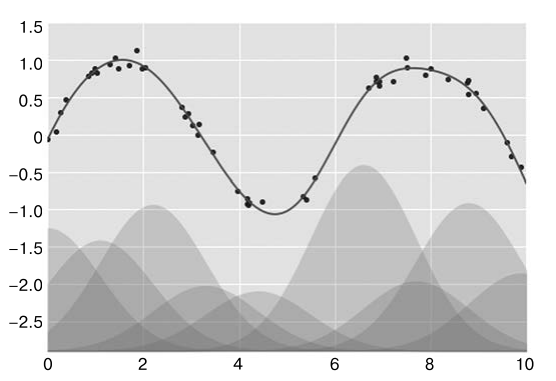
Затененные области на рисунке — нормированные базисные функции, дающие при сложении аппроксимирующую данные гладкую кривую. Эти Гауссовы базисные функции не встроены в библиотеку Scikit-Learn, но мы можем написать для их создания пользовательский преобразователь

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Равномерно распределенные Гауссовы признаки для одномерных входных данных"""
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
    def fit(self, X, y=None):
        # Создаем N центров, распределенных по всему диапазону данных
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_, self.width_, axis=1)

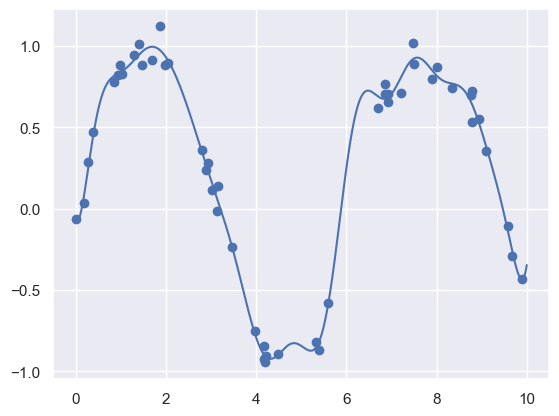

In [19]:
gauss_model = make_pipeline(GaussianFeatures(20), LinearRegression())
gauss_model.fit(x[:, np.newaxis], y)
y_fit = gauss_model.predict(x_fit[:, np.newaxis])
plt.scatter(x, y)
plt.plot(x_fit, y_fit)

## Регуляризация

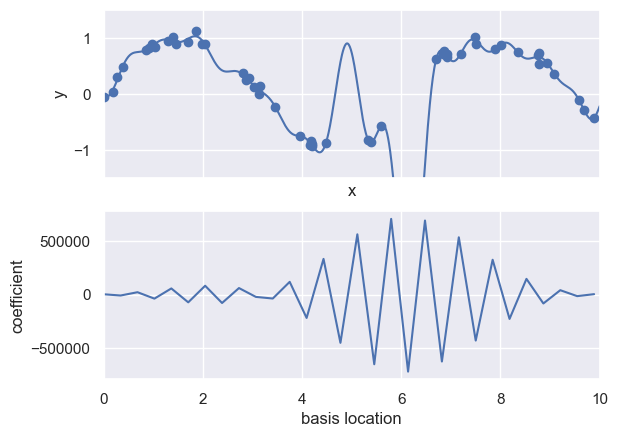

In [21]:
# график коэффициентов Гауссовых базисных функций в соответствии с координатой x

def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y)
    xfit = np.linspace(0, 10, 1000)
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))
    if title:
        ax[0].set_title(title)
    ax[1].plot(model.steps[0][1].centers_, model.steps[1][1].coef_)
    ax[1].set(xlabel='basis location', # Базовое местоположение
              ylabel='coefficient', # Коэффициент
              xlim=(0, 10))
    
model = make_pipeline(GaussianFeatures(30), LinearRegression())
basis_plot(model)

Нижняя часть демонстрирует амплитуду базисной функции в каждой из точек. Это типичное поведение для переобучения с перекрытием областей определения базисных функций: коэффициенты соседних базисных функций усиливают и подавляют друг друга. 

Мы знаем, что подобное поведение приводит к проблемам и было бы неплохо ограничивать подобные пики в модели
явным образом, «накладывая штраф» на большие значения параметров модели. Подобное «штрафование» известно под названием **регуляризации** и существует в нескольких вариантах.


### Гребневая регрессия (L2-регуляризация)

Вероятно, самый часто встречающийся вид регуляризации — гребневая регрессия (ridge regression), или L2-регуляризация (L2
-regularization), также иногда называемая регуляризацией Тихонова (Tikhonov regularization). Она заключается в наложении штрафа на сумму квадратов (евклидовой нормы) коэффициентов модели. В данном случае штраф для модели будет равен:
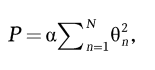
где α — свободный параметр, служащий для управления уровнем штрафа

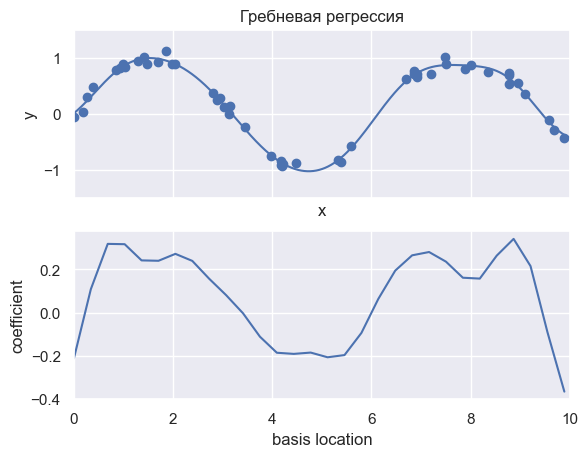

In [29]:
from sklearn.linear_model import Ridge
model = make_pipeline(GaussianFeatures(30), Ridge(alpha=0.1))
basis_plot(model, title='Гребневая регрессия')

В предельном случае α → 0 мы получаем результат, соответствующий стандартной линейной регрессии.
В предельном случае α → ∞ будет происходить подавление любого отклика модели

### Лассо-регуляризация (L1)

Лассо-регуляризация включает штрафование на сумму абсолютных значений (L1-норма) коэффициентов регрессии:
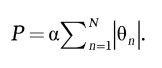

C:\Users\Данила\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.136e-03, tolerance: 2.065e-03
  model = cd_fast.enet_coordinate_descent(


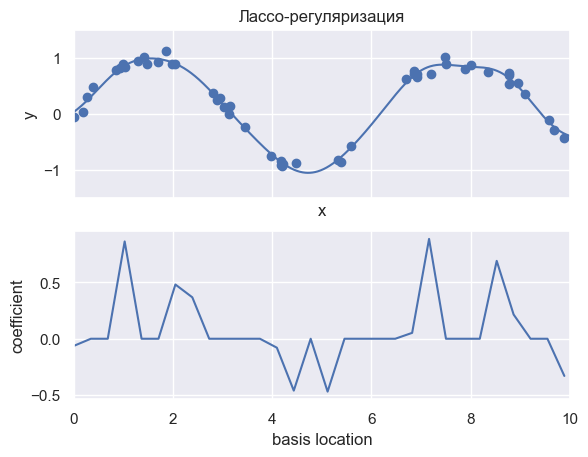

In [30]:
from sklearn.linear_model import Lasso
model = make_pipeline(GaussianFeatures(30), Lasso(alpha=0.001))
basis_plot(model, title='Лассо-регуляризация')